In [2]:
#load libraries 
import time,os
from matplotlib.offsetbox import AnchoredText
import sys,pandas as pd, matplotlib , matplotlib.pyplot as plt, matplotlib.lines , numpy as np,cupy as cp, math, pylab
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
#import cudf
#import ROOT
#from ROOT import TFile

#import root_pandas

#from toggle_cell import hide_cell 
import uproot3
%matplotlib inline

#presets for plot style
from scipy.constants import golden
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (7, 7/golden),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

viridis = cm.get_cmap('viridis', 12)
inferno = cm.get_cmap('inferno', 12)
autumn = cm.get_cmap('autumn', 12)

#physical_devices = tf.config.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], True)
#tf.config.experimental.set_memory_growth(physical_devices[1], True)
rc = plt.rc
rc('text', usetex=False)
import matplotlib as mpl
rc('font', family='serif')
rc('text', usetex=False)
rc('font', size=15)
rc('xtick', labelsize=15)
rc('ytick', labelsize=15)
rc('legend', fontsize=15)
import root_pandas,glob

import gc

def read_n(pattern, n):
    if not '*' in pattern:
        a = root_pandas.read_root(pattern,chunksize=int(n))
    else:
        a = root_pandas.read_root(glob.glob(pattern),chunksize=int(n))
    for b in a:
        del a
        print(n)
        return b

from scipy.optimize import curve_fit

image_dir='../images'

import misc_util,correlation_plots

import imp
imp.reload(correlation_plots)

/home/sebouh/.local/lib/python3.8/site-packages/uproot3/__init__.py:127: FutureWarning: Consider switching from 'uproot3' to 'uproot', since the new interface became the default in 2020.

    pip install -U uproot

In Python:

    >>> import uproot
    >>> with uproot.open(...) as file:
    ...

  warnings.warn(
/home/sebouh/.local/lib/python3.8/site-packages/awkward0/__init__.py:12: FutureWarning: Consider switching from 'awkward0' to 'awkward', since the new interface became the default in 2020.

    pip install -U awkward

In Python:

    >>> import awkward as ak
    >>> new_style_array = ak.from_awkward0(old_style_array)
    >>> old_style_array = ak.to_awkward0(new_style_array)

  warnings.warn(


<module 'correlation_plots' from '/home/sebouh/sidis_tuples/python/correlation_plots.py'>

In [3]:
#sets =  "D_C C D_Fe Fe Pb D_Pb".split()
#sets += "MC_D2 MC_C MC_Fe MC_Pb".split()
#sets += "no_ecuts_D_C no_ecuts_C no_ecuts_D_Fe no_ecuts_Fe no_ecuts_Pb no_ecuts_D_Pb".split()
#sets += "xQ2_D_C xQ2_C xQ2_D_Fe xQ2_Fe xQ2_Pb xQ2_D_Pb".split()

#dfs_mixed = {a : root_pandas.read_root("../../eg2/python/mixed_%s.root"%a)  for a in sets}

mixtag='xQ2_'
dfs_mixed = {a : root_pandas.read_root(f"../../eg2/python/mixed_{mixtag}{a}.root")  for a in "D_C C D_Fe Fe Pb D_Pb MC_D2 MC_C MC_Fe MC_Pb".split()}

In [4]:
dfs_data = {a : root_pandas.read_root("/home/seba/CreatePairTuples/Pairs_%s.root" %a.replace("D_",""),a) for a in "D_C C D_Fe Fe Pb D_Pb".split()}


dfs_trigger = {a : root_pandas.read_root("/home/seba/CreatePairTuples/Pairs_%s.root" %a.replace("D_",""),a+"_trigger") for a in "D_C C D_Fe Fe Pb D_Pb".split()}



In [5]:
#now load MC
dfs_data.update({"MC_"+ a : root_pandas.read_root("/home/seba/CreatePairTuples/MC_Pairs_%s.root" %a,a) for a in "Pb D C Fe".split()})




In [6]:
dfs_trigger.update({"MC_"+ a : root_pandas.read_root("/home/seba/CreatePairTuples/MC_Pairs_%s.root" %a,a + "_trigger") for a in "Pb D C Fe".split()})



In [7]:
for dct in dfs_mixed,dfs_data, dfs_trigger:
    dct['D'] = pd.concat([dct['D_'+a] for a in 'C Fe Pb'.split()])

In [9]:
#for dct in dfs_mixed,:
#    for mixtag in 'xQ2_',:
#        dct[mixtag+'D'] = pd.concat([dct[mixtag+'D_'+a] for a in 'C Fe Pb'.split()])


In [10]:
def applyCut(inputDataframe, cut, text=None):
    nbeforecut = inputDataframe.shape[0]
    cutDataframe = None
    if nbeforecut>0:
        cutDataframe = inputDataframe.query(cut)
        if text:
            print (text, cutDataframe.shape[0], ' (%2.2f '%(100.0*cutDataframe.shape[0]/nbeforecut), '%)')
    return cutDataframe

def applyCuts(fullDataframe,name='default',isMC=False,isTrigger=True): 
    dataframe = fullDataframe
    if(dataframe.shape[0]>0):
        print ('Entries before cut ', dataframe.shape[0])
    dataframe.eval('inelasticity = nu/5.014', inplace=True)
    dataframe.eval('h1_e = h1_z*nu', inplace=True)
    dataframe.eval('h1_p = sqrt(h1_e*h1_e-0.13957*0.13957)', inplace=True)
    dataframe = applyCut(dataframe, 'Q2>1.0 and Q2<4.0', 'Q2>1.0 and Q2<4.0')
    #dataframe = applyCut(dataframe, 'Nu>3.0 and Nu<3.5', '3.0 < Nu < 3.5')
    #dataframe = applyCut(dataframe, 'h_z>0.5', 'h_z>0.5 :')
    dataframe = applyCut(dataframe, 'h1_p <2.5 ', 'h1_p<2.5 ')
    dataframe = applyCut(dataframe, 'inelasticity<0.85','inelasticity < 0.85')
    dataframe = applyCut(dataframe, 'abs(h1_pid)==211', 'h1_pid = pions (trigger)')
    dataframe = applyCut(dataframe, 'nu>2.2 and nu<4.2', 'Nu>2.2 and Nu<4.2')
    dataframe = applyCut(dataframe, 'h1_z <1.0', 'h1_z <1.0')
   
    return dataframe

def applyCutsPair(fullDataframe,name='default',isMC=False,dipion=False,pi_p=False):
    print ('Starting election on dipion variables')
    if (isMC):
        print ('This is MC')
    else: 
        print ('This is Data')
    
    dataframe = fullDataframe
    dataframe.eval('pair_pt = sqrt((h1_p*sin(h1_th)*cos(h1_ph)+h2_p*sin(h2_th)*cos(h2_ph))**2+(h1_p*sin(h1_th)*sin(h1_ph)+h2_p*sin(h2_th)*sin(h2_ph))**2)',inplace=True)
    dataframe.eval('z_tot = h1_z+ h2_z', inplace=True)
    dataframe.eval('h1_e = h1_z*nu', inplace=True)
    dataframe.eval('h1_p = sqrt(h1_e*h1_e-0.13957*0.13957)', inplace=True)
    dataframe.eval('h2_e = h2_z*nu', inplace=True)
    dataframe.eval('h2_mass = 0.13957*(abs(h2_pid)==211)+.93827208816*(abs(h2_pid)==2212)', inplace=True)
    dataframe.eval('h2_p = sqrt(h2_e*h2_e-h2_mass*h2_mass)', inplace=True)
    dataframe = applyCut(dataframe, 'Q2>1.0 and Q2<4.0', 'Q2>1.0 :')
    #dataframe = applyCut(dataframe, 'nu>3.0 and nu<3.5', '3.0 < nu < 3.5')
    dataframe = applyCut(dataframe, 'h1_z>0.5', 'h1_z>0.5 :')
    dataframe = applyCut(dataframe, 'h1_p<2.5', 'h1_p<2.5 GeV ')
    dataframe = applyCut(dataframe, 'h2_p<2.5', 'h2_p<2.5 GeV')
    #dataframe = applyCut(dataframe, 'h1_pid*h2_pid<0', 'Opposite sign pairs')
    dataframe.eval('pair_pt2 = pair_pt*pair_pt', inplace=True)
    if dipion:
        dataframe = applyCut(dataframe, 'abs(h2_pid)==211', 'secondary hadrons are pions') 
    if pi_p:
        dataframe = applyCut(dataframe, 'h2_pid==2212', 'secondary hadrons are protons') 
    dataframe = applyCut(dataframe, 'h2_p>0.2', 'h2_p>0.2')
    dataframe = applyCut(dataframe, 'h1_p>0.2', 'h1_p>0.2')
    dataframe = applyCut(dataframe, 'h2_z<1.0', 'h1_z<1.0')
    
    #convert stuff to radians
    if(max(dataframe[:1000].h2_th)>np.pi):
        for f in 'h2_th h1_th h1_ph h2_ph'.split():
            dataframe[f]*=np.pi/180
    ## Theta cuts are not applied in the GiBUU case
    if (not isMC):
        dataframe = applyCut(dataframe, 'h2_th<120*3.14159/180 and h2_th>10*3.14159/180', '10<h2_th<120')
        dataframe = applyCut(dataframe, '(h2_pid==2212) | (h2_pid==211) | (h2_pid==-211 & h2_th>25*3.14159/180 & h2_th<90*3.14159/180) | (h2_pid==-211 & h2_th<40*3.14159/180 & h2_th>25*3.14159/180 & h2_p>0.5)','Theta/P fiducial region selected')
        dataframe = applyCut(dataframe, 'h1_th<120*3.14159/180 and h1_th>10*3.14159/180', '10< h1_th<120')
        dataframe = applyCut(dataframe, '(h1_pid==211) | (h1_pid==-211 & h1_th>25*3.14159/180 & h1_th<90*3.14159/180) | (h1_pid==-211 & h1_th<40*3.14159/180 & h1_th>25*3.14159/180 & h1_p>0.5)','Theta/P fiducial region selected for trigger')
        
    return dataframe



for key in list(dfs_data.keys()):
    if '_2pi' in key or '_pi_p' in key:
        continue
    df = dfs_data[key]
    print(df.columns)
    df.eval('inelasticity = nu/5.014', inplace=True)
    df.eval('diff_phi_cm = h1_cm_ph-h2_cm_ph', inplace=True)
    df.eval('pi='+str(np.pi),inplace=True) #not sure why eval doesn't know what pi is.  
    df.eval('diff_phi_cm = 2*pi*(diff_phi_cm<-pi)-2*pi*(diff_phi_cm>pi)')
    df.eval('h1_e = h1_z*nu', inplace=True)
    df.eval('h2_e = h2_z*nu', inplace=True)
    df.eval('h2_mass = 0.13957*(abs(h2_pid)==211)+.93827208816*(abs(h2_pid)==2212)', inplace=True)
    df.eval('h1_p = sqrt(h1_e*h1_e-0.13957*0.13957)', inplace=True)
    df.eval('h2_p = sqrt(h2_e*h2_e-h2_mass*h2_mass)', inplace=True)
    df.rename(columns={'drap':'diff_rap_cm'},inplace=True)
    print(df.columns)
    dfs_data[key+"_2pi"] = applyCuts(applyCutsPair(df,dipion=True))
    dfs_data[key+"_pi_p"] = applyCuts(applyCutsPair(df,pi_p=True))
for key in list(dfs_mixed.keys()): 
    if '_2pi' in key or '_pi_p' in key:
        continue
    print('key is ',key)
    dfs_mixed[key+"_2pi"] = applyCuts(applyCutsPair(dfs_mixed[key],dipion=True))
    dfs_mixed[key+"_pi_p"] = applyCuts(applyCutsPair(dfs_mixed[key],pi_p=True))
for key in list(dfs_trigger.keys()):
    if '_2pi' in key or '_pi_p' in key:
        continue
    dfs_trigger[key] = applyCuts(dfs_trigger[key])

Index(['dphi', 'dphi_lab', 'drap', 'h1_z', 'h2_z', 'h1_cm_pt', 'h2_cm_pt',
       'h1_xf', 'h2_xf', 'h1_rap', 'ycm', 'h2_rap', 'h1_pid', 'h2_pid',
       'h1_cm_ph', 'h2_cm_ph', 'h1_cm_th', 'h2_cm_th', 'pair_mass', 'pair_pt',
       'mx_eh1h2x', 'mx_eh1x', 'mx_eh2x', 't', 'Q2', 'nu', 'W', 'x', 'u',
       'h1_ph', 'h1_th', 'h2_ph', 'h2_th', '__index__'],
      dtype='object')
Index(['dphi', 'dphi_lab', 'diff_rap_cm', 'h1_z', 'h2_z', 'h1_cm_pt',
       'h2_cm_pt', 'h1_xf', 'h2_xf', 'h1_rap', 'ycm', 'h2_rap', 'h1_pid',
       'h2_pid', 'h1_cm_ph', 'h2_cm_ph', 'h1_cm_th', 'h2_cm_th', 'pair_mass',
       'pair_pt', 'mx_eh1h2x', 'mx_eh1x', 'mx_eh2x', 't', 'Q2', 'nu', 'W', 'x',
       'u', 'h1_ph', 'h1_th', 'h2_ph', 'h2_th', '__index__', 'inelasticity',
       'diff_phi_cm', 'pi', 'h1_e', 'h2_e', 'h2_mass', 'h1_p', 'h2_p'],
      dtype='object')
Starting election on dipion variables
This is Data
Q2>1.0 : 932821  (100.00  %)
h1_z>0.5 : 530131  (56.83  %)
h1_p<2.5 GeV  454397  (85.71  %)
h2_p<

h1_z <1.0 38334  (100.00  %)
Starting election on dipion variables
This is Data
Q2>1.0 : 1865381  (100.00  %)
h1_z>0.5 : 734962  (39.40  %)
h1_p<2.5 GeV  656707  (89.35  %)
h2_p<2.5 GeV 656429  (99.96  %)
secondary hadrons are protons 270936  (41.27  %)
h2_p>0.2 270936  (100.00  %)
h1_p>0.2 270936  (100.00  %)
h1_z<1.0 270917  (99.99  %)
10<h2_th<120 270917  (100.00  %)
Theta/P fiducial region selected 270917  (100.00  %)
10< h1_th<120 270917  (100.00  %)
Theta/P fiducial region selected for trigger 53099  (19.60  %)
Entries before cut  53099
Q2>1.0 and Q2<4.0 53099  (100.00  %)
h1_p<2.5  53099  (100.00  %)
inelasticity < 0.85 53099  (100.00  %)
h1_pid = pions (trigger) 53099  (100.00  %)
Nu>2.2 and Nu<4.2 52521  (98.91  %)
h1_z <1.0 52521  (100.00  %)
Index(['dphi', 'dphi_lab', 'drap', 'h1_z', 'h2_z', 'h1_cm_pt', 'h2_cm_pt',
       'h1_xf', 'h2_xf', 'h1_rap', 'ycm', 'h2_rap', 'h1_pid', 'h2_pid',
       'h1_cm_ph', 'h2_cm_ph', 'h1_cm_th', 'h2_cm_th', 'pair_mass', 'pair_pt',
       'mx_

Q2>1.0 : 2196429  (100.00  %)
h1_z>0.5 : 1350443  (61.48  %)
h1_p<2.5 GeV  1033362  (76.52  %)
h2_p<2.5 GeV 1030935  (99.77  %)
secondary hadrons are pions 840592  (81.54  %)
h2_p>0.2 840592  (100.00  %)
h1_p>0.2 840592  (100.00  %)
h1_z<1.0 840592  (100.00  %)
10<h2_th<120 840592  (100.00  %)
Theta/P fiducial region selected 840592  (100.00  %)
10< h1_th<120 840592  (100.00  %)
Theta/P fiducial region selected for trigger 150658  (17.92  %)
Entries before cut  150658
Q2>1.0 and Q2<4.0 150658  (100.00  %)
h1_p<2.5  150658  (100.00  %)
inelasticity < 0.85 150658  (100.00  %)
h1_pid = pions (trigger) 150658  (100.00  %)
Nu>2.2 and Nu<4.2 148213  (98.38  %)
h1_z <1.0 148213  (100.00  %)
Starting election on dipion variables
This is Data
Q2>1.0 : 2196429  (100.00  %)
h1_z>0.5 : 1350443  (61.48  %)
h1_p<2.5 GeV  1033362  (76.52  %)
h2_p<2.5 GeV 1030935  (99.77  %)
secondary hadrons are protons 190343  (18.46  %)
h2_p>0.2 190343  (100.00  %)
h1_p>0.2 190343  (100.00  %)
h1_z<1.0 190341  (100

Nu>2.2 and Nu<4.2 180707  (99.21  %)
h1_z <1.0 180707  (100.00  %)
key is  D_C
Starting election on dipion variables
This is Data
Q2>1.0 : 3078859  (100.00  %)
h1_z>0.5 : 1765223  (57.33  %)
h1_p<2.5 GeV  1460957  (82.76  %)
h2_p<2.5 GeV 1460957  (100.00  %)
secondary hadrons are pions 1004740  (68.77  %)
h2_p>0.2 1004740  (100.00  %)
h1_p>0.2 1004740  (100.00  %)
h1_z<1.0 1004740  (100.00  %)
10<h2_th<120 1004740  (100.00  %)
Theta/P fiducial region selected 1004740  (100.00  %)
10< h1_th<120 1004740  (100.00  %)
Theta/P fiducial region selected for trigger 1004740  (100.00  %)
Entries before cut  1004740
Q2>1.0 and Q2<4.0 1004740  (100.00  %)
h1_p<2.5  1004740  (100.00  %)
inelasticity < 0.85 1004740  (100.00  %)
h1_pid = pions (trigger) 1004740  (100.00  %)
Nu>2.2 and Nu<4.2 997435  (99.27  %)
h1_z <1.0 997393  (100.00  %)
Starting election on dipion variables
This is Data
Q2>1.0 : 3078859  (100.00  %)
h1_z>0.5 : 1765223  (57.33  %)
h1_p<2.5 GeV  1460957  (82.76  %)
h2_p<2.5 GeV 146

inelasticity < 0.85 1356269  (100.00  %)
h1_pid = pions (trigger) 1356269  (100.00  %)
Nu>2.2 and Nu<4.2 1346500  (99.28  %)
h1_z <1.0 1346433  (100.00  %)
Starting election on dipion variables
This is Data
Q2>1.0 : 4140760  (100.00  %)
h1_z>0.5 : 2381925  (57.52  %)
h1_p<2.5 GeV  1970494  (82.73  %)
h2_p<2.5 GeV 1970494  (100.00  %)
secondary hadrons are protons 614225  (31.17  %)
h2_p>0.2 614225  (100.00  %)
h1_p>0.2 614225  (100.00  %)
h1_z<1.0 614225  (100.00  %)
10<h2_th<120 614225  (100.00  %)
Theta/P fiducial region selected 614225  (100.00  %)
10< h1_th<120 614225  (100.00  %)
Theta/P fiducial region selected for trigger 614225  (100.00  %)
Entries before cut  614225
Q2>1.0 and Q2<4.0 614225  (100.00  %)
h1_p<2.5  614225  (100.00  %)
inelasticity < 0.85 614225  (100.00  %)
h1_pid = pions (trigger) 614225  (100.00  %)
Nu>2.2 and Nu<4.2 608964  (99.14  %)
h1_z <1.0 608931  (99.99  %)
key is  MC_D2
Starting election on dipion variables
This is Data
Q2>1.0 : 2735457  (100.00  %)
h1

Q2>1.0 and Q2<4.0 1531150  (100.00  %)
h1_p<2.5  1531150  (100.00  %)
inelasticity < 0.85 1531150  (100.00  %)
h1_pid = pions (trigger) 1531150  (100.00  %)
Nu>2.2 and Nu<4.2 1518420  (99.17  %)
h1_z <1.0 1518353  (100.00  %)
Entries before cut  2294598
Q2>1.0 and Q2<4.0 2294597  (100.00  %)
h1_p<2.5  2074782  (90.42  %)
inelasticity < 0.85 2074782  (100.00  %)
h1_pid = pions (trigger) 646069  (31.14  %)
Nu>2.2 and Nu<4.2 638222  (98.79  %)
h1_z <1.0 638207  (100.00  %)
Entries before cut  2087382
Q2>1.0 and Q2<4.0 2087382  (100.00  %)
h1_p<2.5  1908242  (91.42  %)
inelasticity < 0.85 1908242  (100.00  %)
h1_pid = pions (trigger) 479645  (25.14  %)
Nu>2.2 and Nu<4.2 473386  (98.70  %)
h1_z <1.0 473378  (100.00  %)
Entries before cut  3394111
Q2>1.0 and Q2<4.0 3394111  (100.00  %)
h1_p<2.5  3067888  (90.39  %)
inelasticity < 0.85 3067888  (100.00  %)
h1_pid = pions (trigger) 959078  (31.26  %)
Nu>2.2 and Nu<4.2 948765  (98.92  %)
h1_z <1.0 948748  (100.00  %)
Entries before cut  3247856

In [11]:
for df in dfs_mixed.values():
    df.eval('diff_rap_cm=0.5*log((h1_e+sqrt(h1_p**2-h1_cm_pt**2))/(h1_e-sqrt(h1_p**2-h1_cm_pt**2)))-0.5*log((h2_e+sqrt(h2_p**2-h2_cm_pt**2))/(h2_e-sqrt(h2_p**2-h2_cm_pt**2)))',inplace=True)

In [12]:
print(dfs_data['C'].columns)

Index(['dphi', 'dphi_lab', 'diff_rap_cm', 'h1_z', 'h2_z', 'h1_cm_pt',
       'h2_cm_pt', 'h1_xf', 'h2_xf', 'h1_rap', 'ycm', 'h2_rap', 'h1_pid',
       'h2_pid', 'h1_cm_ph', 'h2_cm_ph', 'h1_cm_th', 'h2_cm_th', 'pair_mass',
       'pair_pt', 'mx_eh1h2x', 'mx_eh1x', 'mx_eh2x', 't', 'Q2', 'nu', 'W', 'x',
       'u', 'h1_ph', 'h1_th', 'h2_ph', 'h2_th', '__index__', 'inelasticity',
       'diff_phi_cm', 'pi', 'h1_e', 'h2_e', 'h2_mass', 'h1_p', 'h2_p',
       'z_tot'],
      dtype='object')


In [27]:
# plt.hist(dfs_data['C_pi_p'].eval('diff_rap_cm'),bins=100,histtype='step')
# plt.hist(dfs_data['C_pi_p'].eval('0.5*log((h1_e+sqrt(h1_p**2-h1_cm_pt**2))/(h1_e-sqrt(h1_p**2-h1_cm_pt**2)))-0.5*log((h2_e+sqrt(h2_p**2-h2_cm_pt**2))/(h2_e-sqrt(h2_p**2-h2_cm_pt**2)))'),bins=100,histtype='step')
# plt.show()
# plt.hist(dfs_mixed['C_pi_p'].eval('diff_rap_cm'),bins=100,histtype='step')
# plt.hist(dfs_mixed['C_pi_p'].eval('0.5*log((h1_e+sqrt(h1_p**2-h1_cm_pt**2))/(h1_e-sqrt(h1_p**2-h1_cm_pt**2)))-0.5*log((h2_e+sqrt(h2_p**2-h2_cm_pt**2))/(h2_e-sqrt(h2_p**2-h2_cm_pt**2)))'),bins=100,histtype='step')
# plt.show()


[0.     0.3125 0.625  0.9375 1.25   1.5625 1.875  2.1875 2.5   ]
i= 1


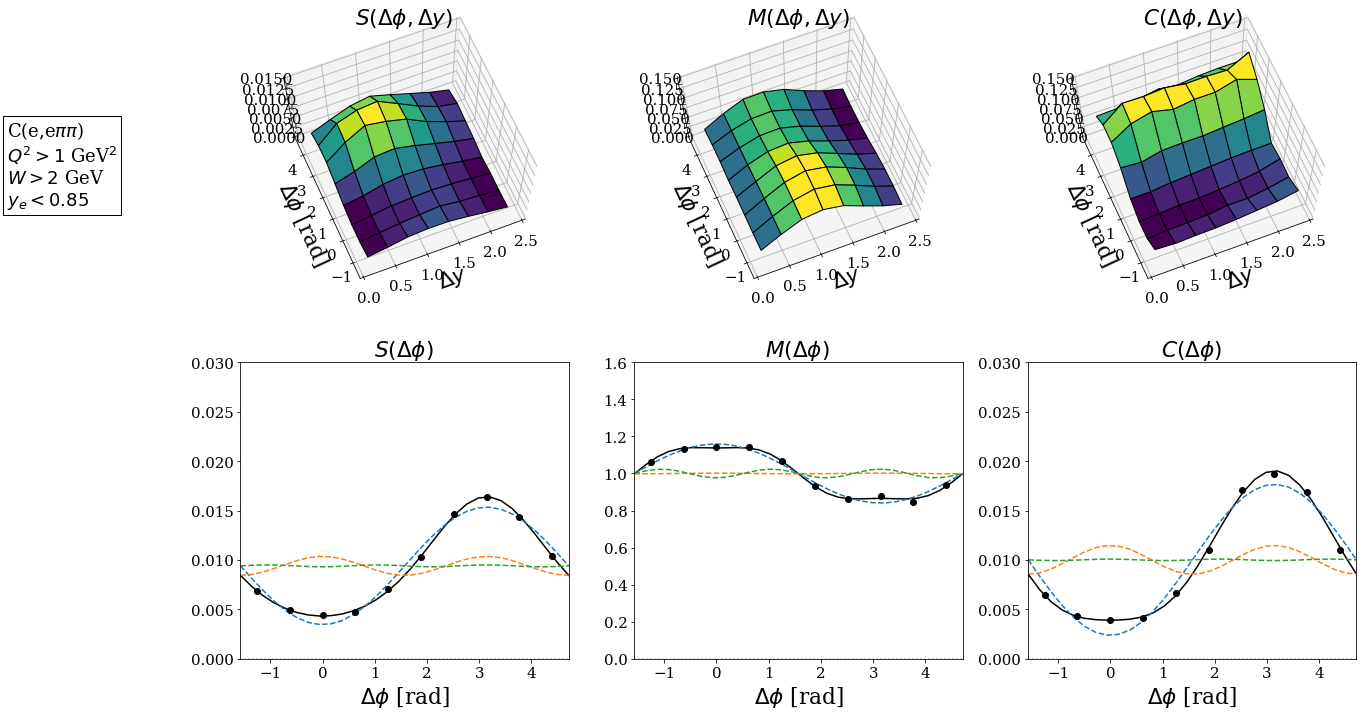

[0.     0.3125 0.625  0.9375 1.25   1.5625 1.875  2.1875 2.5   ]
i= 1


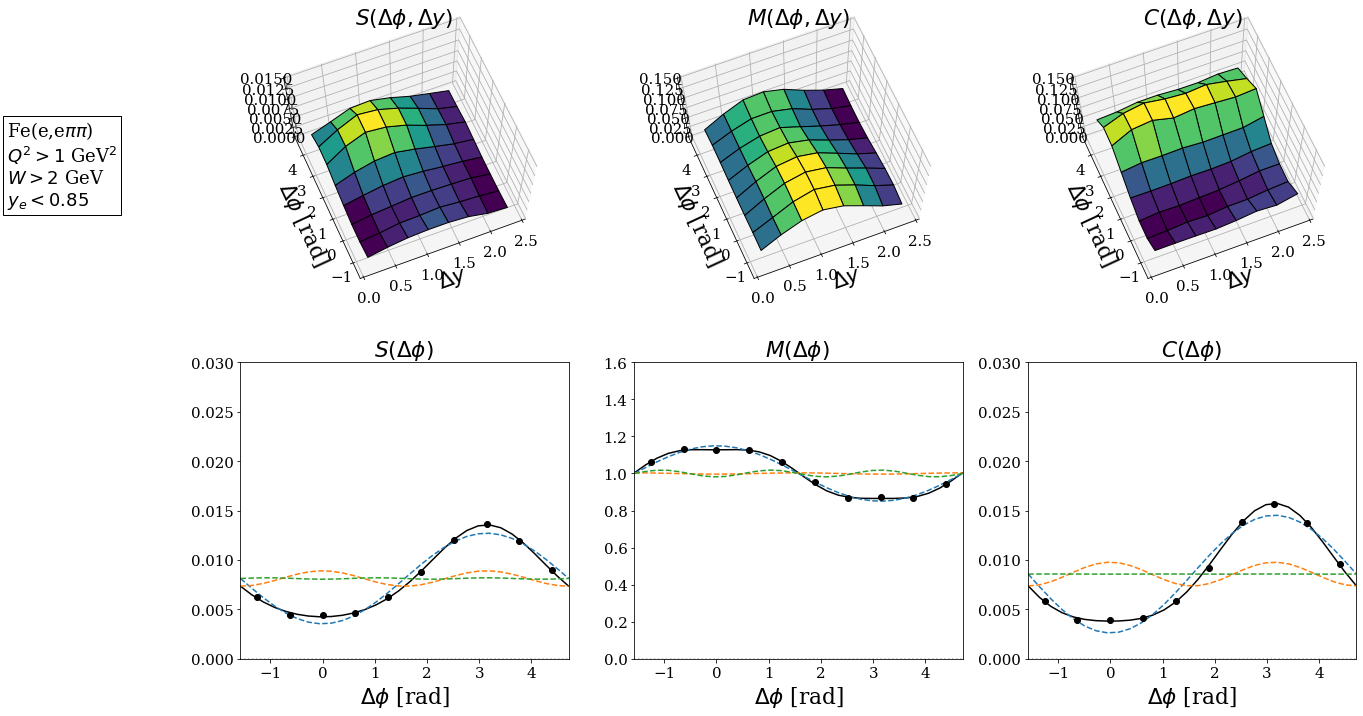

[0.     0.3125 0.625  0.9375 1.25   1.5625 1.875  2.1875 2.5   ]
i= 1


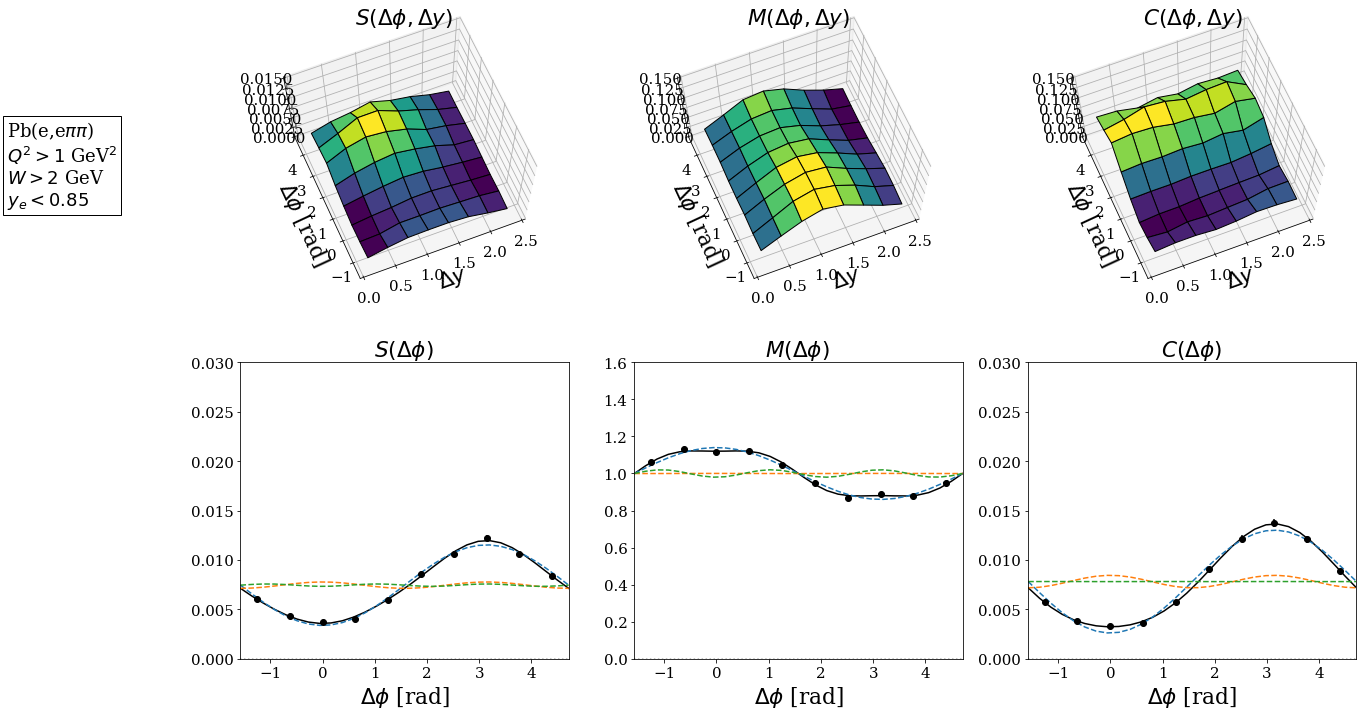

[0.     0.3125 0.625  0.9375 1.25   1.5625 1.875  2.1875 2.5   ]
i= 1


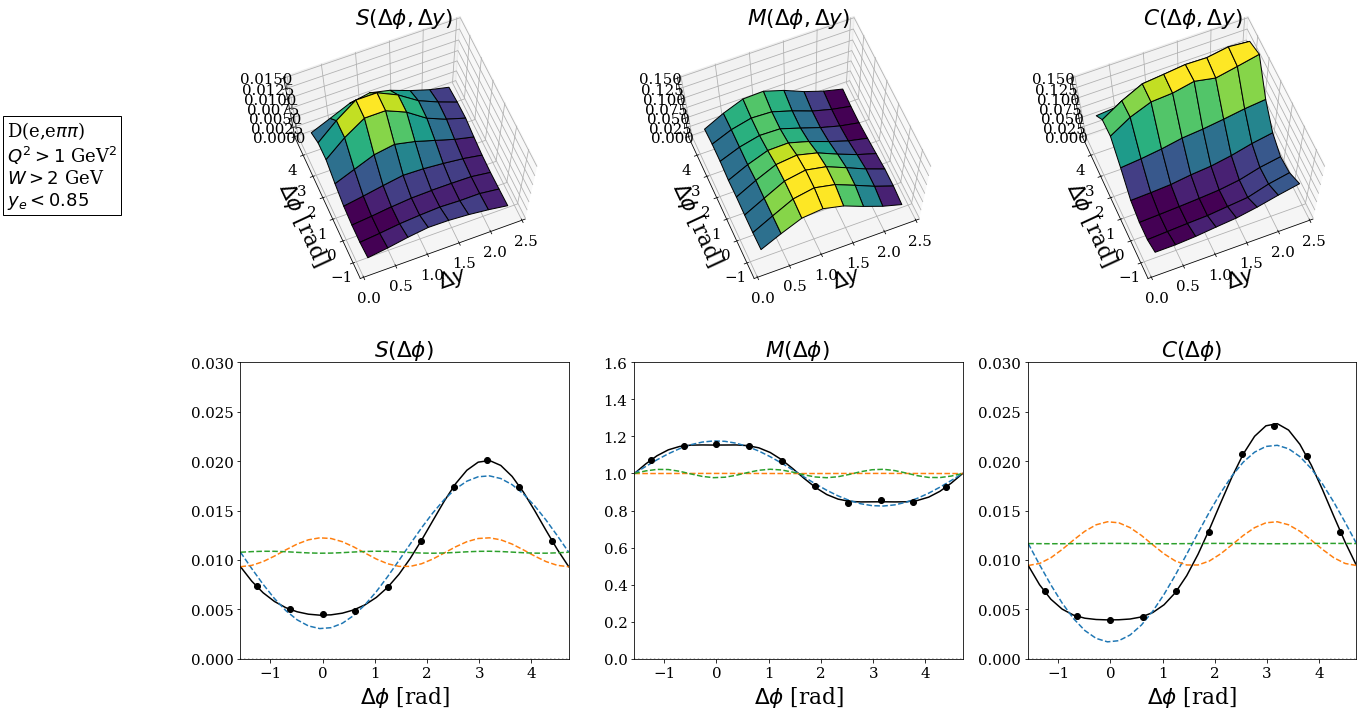

[0.     0.3125 0.625  0.9375 1.25   1.5625 1.875  2.1875 2.5   ]
i= 1


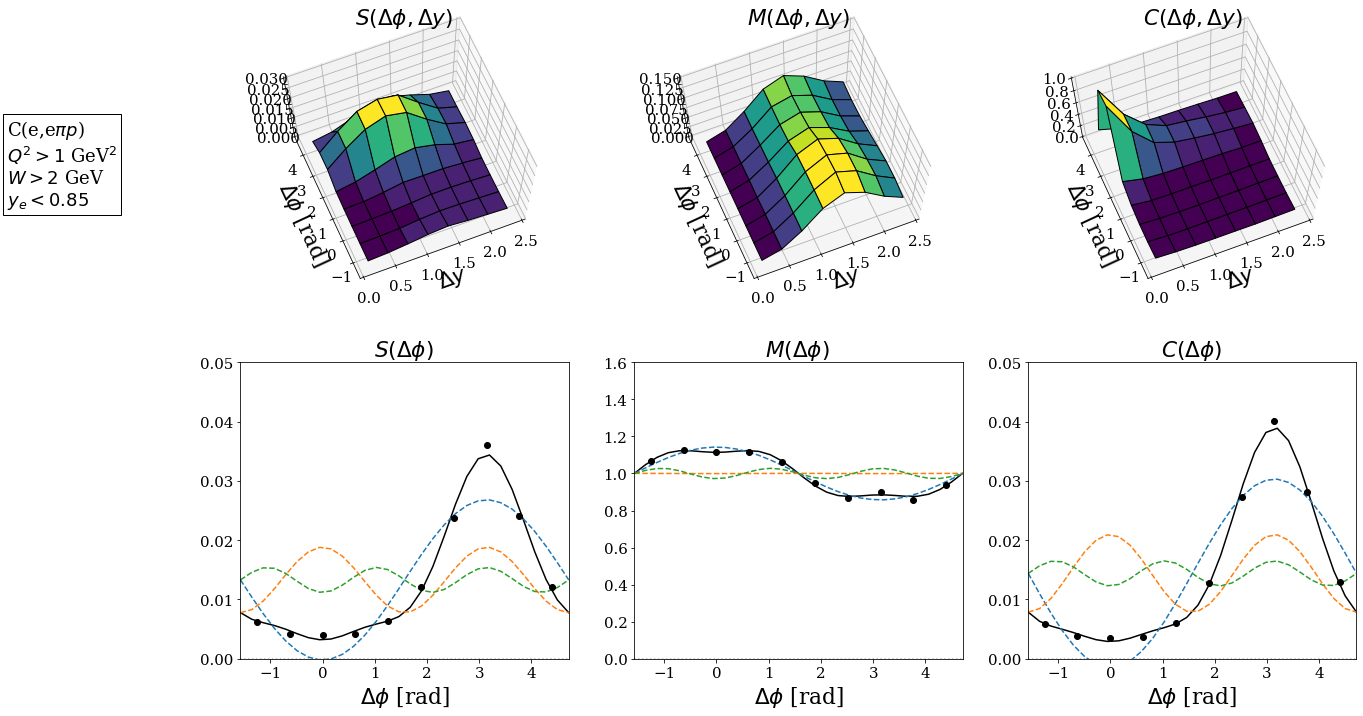

[0.     0.3125 0.625  0.9375 1.25   1.5625 1.875  2.1875 2.5   ]
i= 1


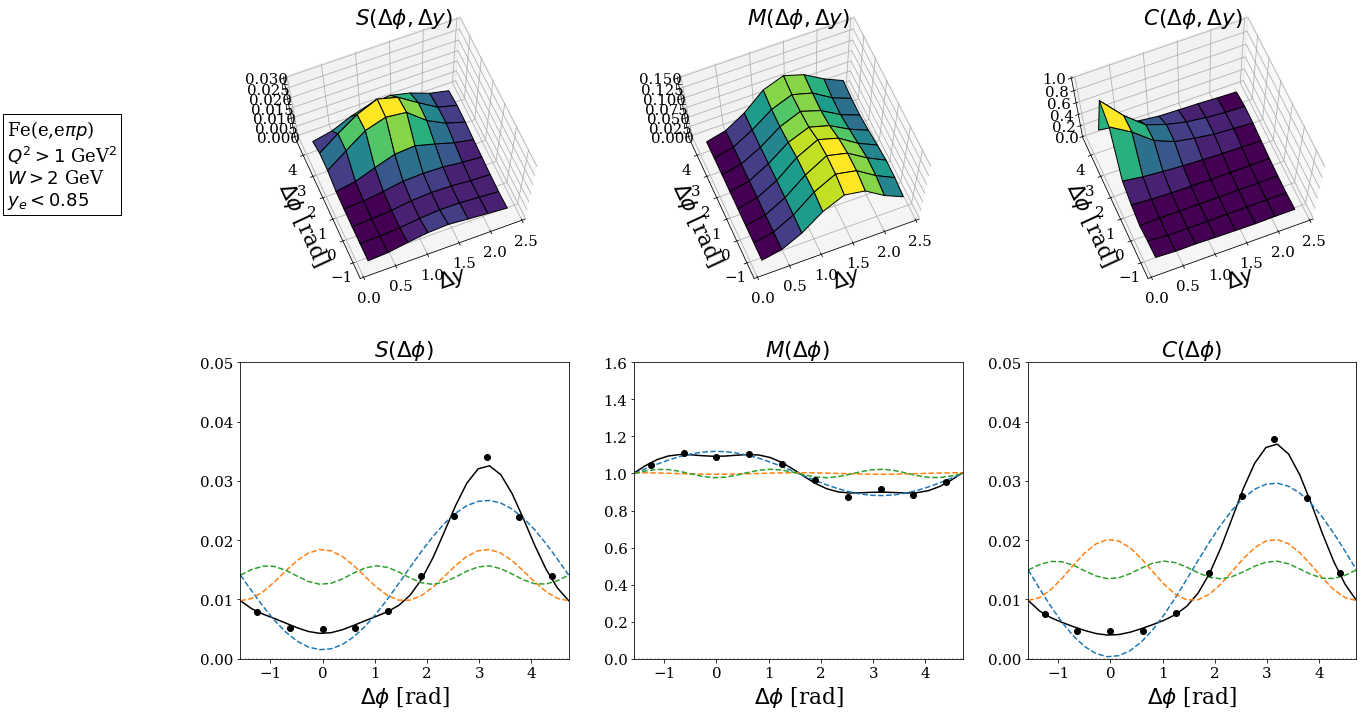

[0.     0.3125 0.625  0.9375 1.25   1.5625 1.875  2.1875 2.5   ]
i= 1


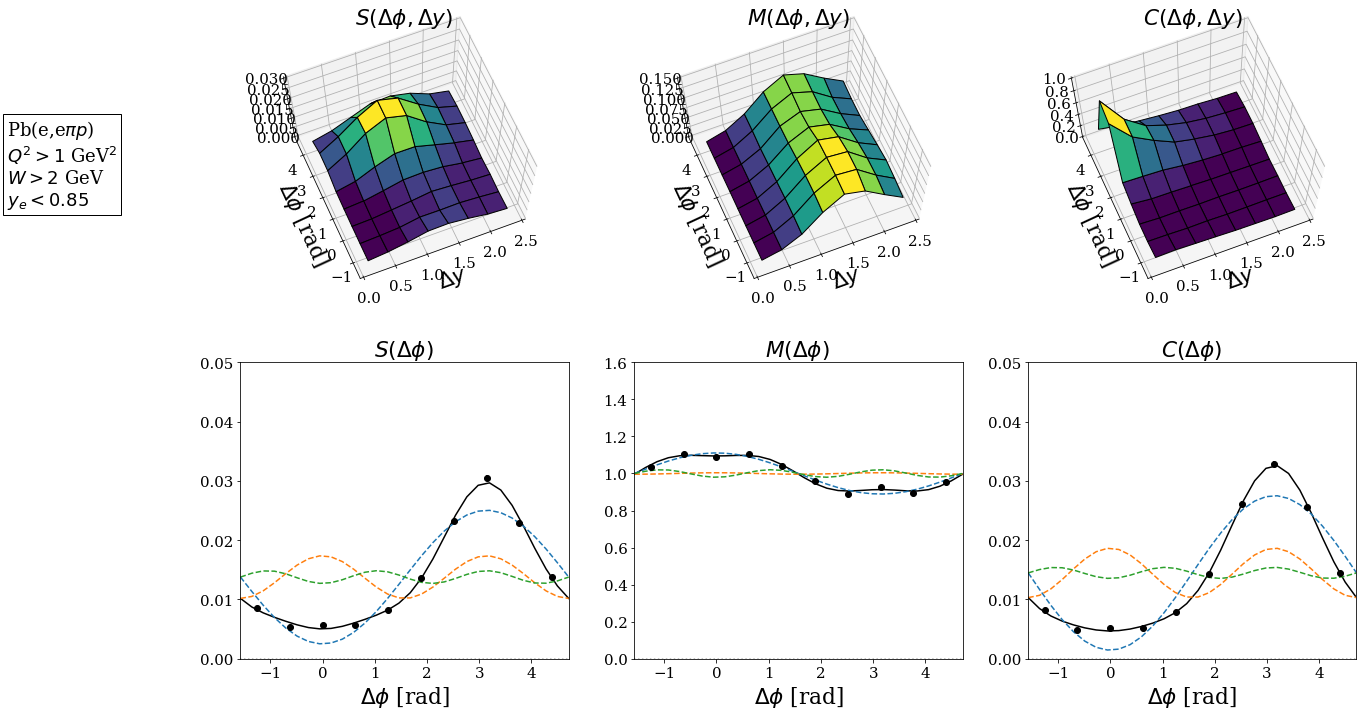

[0.     0.3125 0.625  0.9375 1.25   1.5625 1.875  2.1875 2.5   ]
i= 1


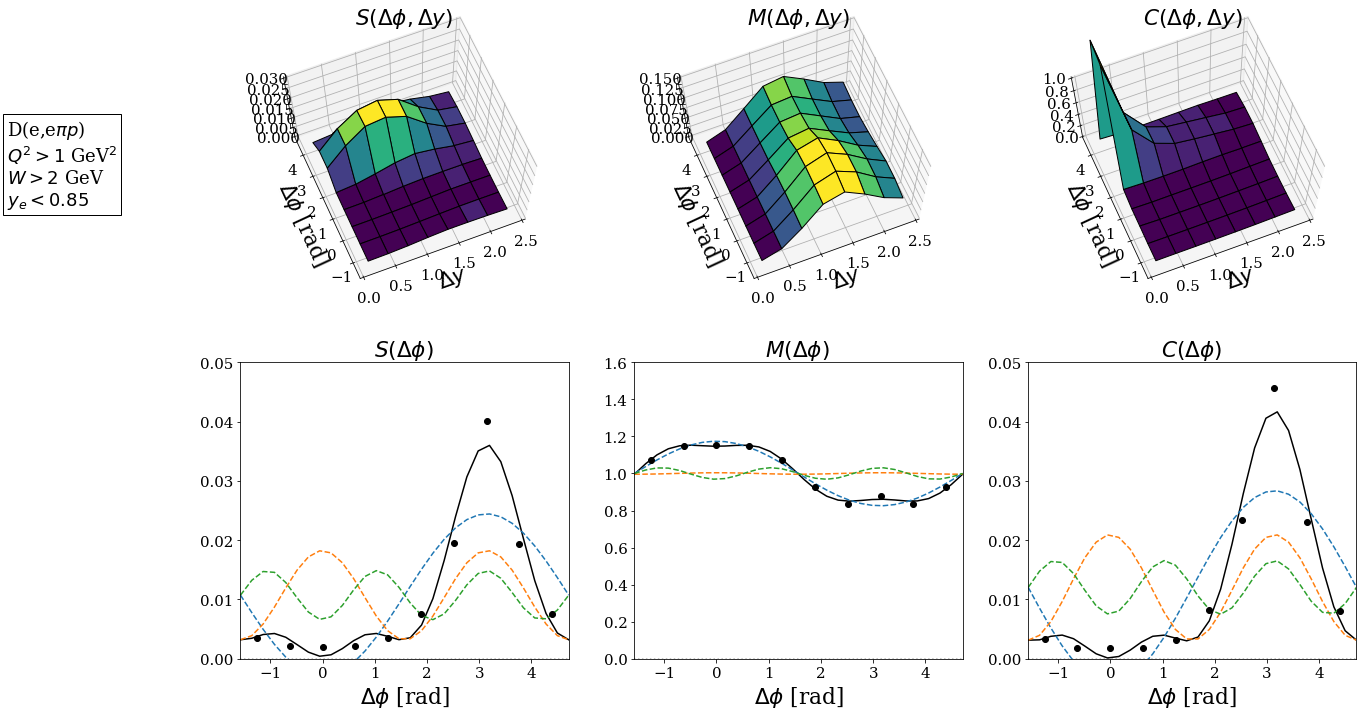

In [15]:
imp.reload(correlation_plots)
query = "h2_z>0.1"
labels = {'_2pi': '$\\pi\\pi$', '_pi_p':'$\\pi p$'}
for topo in '_2pi _pi_p'.split():
    for a in 'C Fe Pb D'.split():
        data = dfs_data[a+topo].query(query)
        mixed = dfs_mixed[a+topo].query(query)
        triggers = dfs_trigger[a]
        if topo == '_2pi':
            zlims = ((0,0.015),(0,0.15),(0,0.15))
            ylims = ((0,0.03),(0,1.6),(0,0.03))
        else :
            zlims = ((0,0.03),(0,0.15),(0,1))
            ylims = ((0,0.05),(0,1.6),(0,0.05))
        fig,axs = correlation_plots.dphi_deta_plot_3_proj(data,mixed,df_triggers=triggers,
                      deta_range=(0,2.5),projyrange=(0,2.5),bins=8,bins1d=10,
                      text=a + "(e,e"+ labels[topo]+")\n$Q^2>1$ GeV$^2$\n$W>2$ GeV\n$y_e<0.85$",
                        zlims=zlims,ylims=ylims)
        #axs[4].errorbar(*pi_p_M_from_mc,color='g',marker='o') 
        #axs[4].text(-0.5,0.027,"correction from event mixing",fontsize=18,color='k')
        #axs[4].text(-0.5,0.01,"alt. correction from MC",fontsize=18,color='g') 
        plt.savefig(image_dir + "/smc_EG2_%s%s.pdf" %(a,topo),bbox_inches='tight')
        plt.show()
        gc.collect()

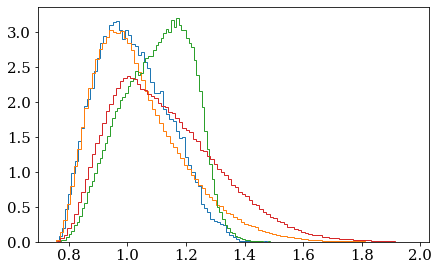

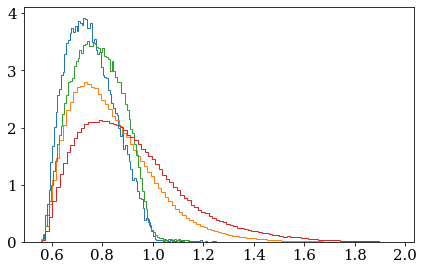

In [26]:
plt.hist(dfs_data['C_pi_p'].eval('h1_z+h2_z'),bins=100,density=True,histtype='step')
plt.hist(dfs_mixed['C_pi_p'].eval('h1_z+h2_z'),bins=100,density=True,histtype='step')
plt.hist(dfs_data['MC_C_pi_p'].eval('h1_z+h2_z'),bins=100,density=True,histtype='step')
plt.hist(dfs_mixed['MC_C_pi_p'].eval('h1_z+h2_z'),bins=100,density=True,histtype='step')
plt.show()

plt.hist(dfs_data['C_2pi'].eval('h1_z+h2_z'),bins=100,density=True,histtype='step')
plt.hist(dfs_mixed['C_2pi'].eval('h1_z+h2_z'),bins=100,density=True,histtype='step')
plt.hist(dfs_data['MC_C_2pi'].eval('h1_z+h2_z'),bins=100,density=True,histtype='step')
plt.hist(dfs_mixed['MC_C_2pi'].eval('h1_z+h2_z'),bins=100,density=True,histtype='step')
plt.show()


plt.show()

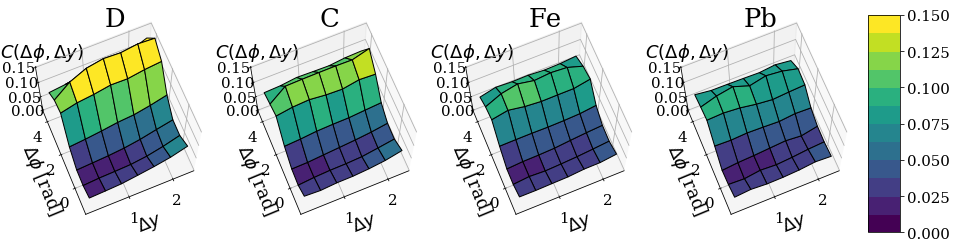

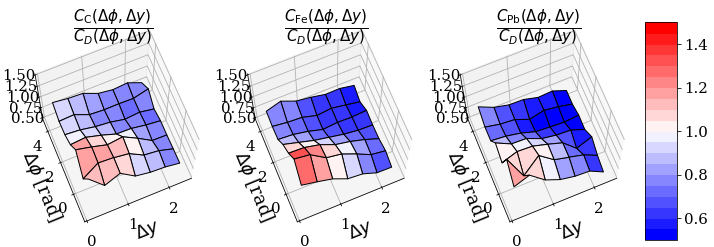

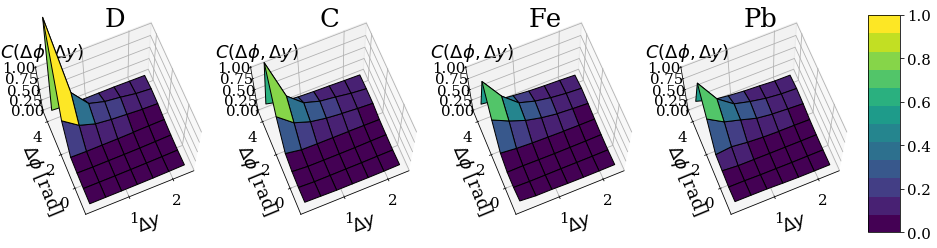

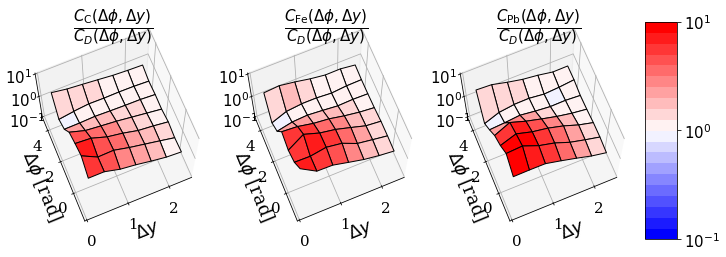

In [18]:
import corr_plots_nuclear
imp.reload(corr_plots_nuclear)
targets = 'D C Fe Pb D_C D_Fe D_Pb'.split()
q = 'h2_z>0.1 and h1_z>0.5'

projyrange =(0,2.5)
bins = 7
corr_plots_nuclear.summary_plot([dfs_data[a + '_2pi'].query(q) for a in targets],
                                [dfs_mixed[a + '_2pi'].query(q) for a in targets],
                                [dfs_trigger[a] for a in targets], bins=bins,projyrange=projyrange,
                                text="$\\pi\\pi$\n$Q^2>1$ GeV$^2$\n$y_e<0.85$\n$W>2$ GeV",
                                zlims=(0,0.15),zlimrat=(0.5,1.5),include_1d=False,topRowOnly=True)
plt.savefig(image_dir + "/summary_2d_2pi_top.pdf",bbox_inches='tight')

corr_plots_nuclear.summary_plot([dfs_data[a + '_2pi'].query(q) for a in targets],
                                [dfs_mixed[a + '_2pi'].query(q) for a in targets],
                                [dfs_trigger[a] for a in targets], bins=bins,projyrange=projyrange ,
                                text="$\\pi\\pi$\n$Q^2>1$ GeV$^2$\n$y_e<0.85$\n$W>2$ GeV",
                                zlims=(0,0.15),zlimrat=(0.5,1.5),include_1d=False,bottomRowOnly=True)
plt.savefig(image_dir + "/summary_2d_2pi_bottom.pdf",bbox_inches='tight')


corr_plots_nuclear.summary_plot([dfs_data[a + '_pi_p'].query(q) for a in targets],
                                [dfs_mixed[a + '_pi_p'].query(q) for a in targets],
                                [dfs_trigger[a] for a in targets],projyrange=projyrange,bins=bins,ylimrat=(0,.1), 
                                zlims=(0,1),text="$\\pi p$\n$Q^2>1$ GeV$^2$\n$y_e<0.85$\n$W>2$ GeV",
                                zlimrat=(.1,10),include_1d=False,topRowOnly=True,logzrat=True)
plt.savefig(image_dir + "/summary_2d_pi_p_top.pdf",bbox_inches='tight')

corr_plots_nuclear.summary_plot([dfs_data[a + '_pi_p'].query(q) for a in targets],
                                [dfs_mixed[a + '_pi_p'].query(q) for a in targets],
                                [dfs_trigger[a] for a in targets],projyrange=projyrange,bins=bins,ylimrat=(0,.1), 
                                zlims=(0,1),text="$\\pi p$\n$Q^2>1$ GeV$^2$\n$y_e<0.85$\n$W>2$ GeV",
                                zlimrat=(.1,10),include_1d=False,bottomRowOnly=True,logzrat=True,surfrat=True)
plt.savefig(image_dir + "/summary_2d_pi_p_bottom.pdf",bbox_inches='tight')

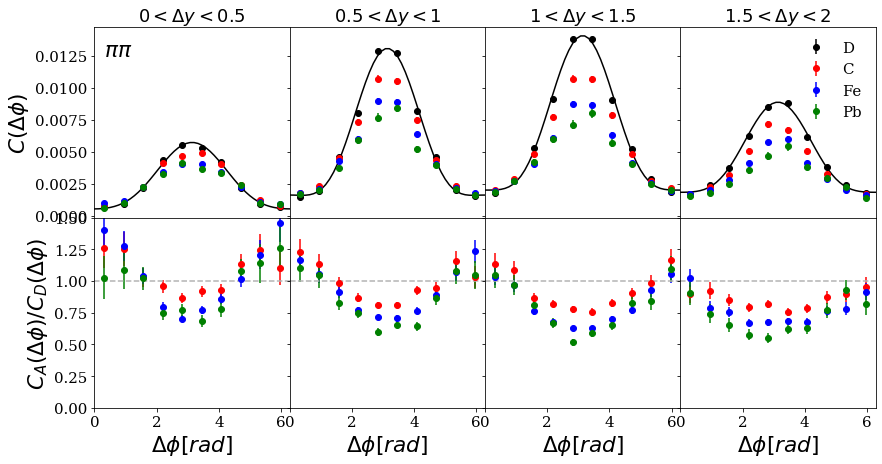

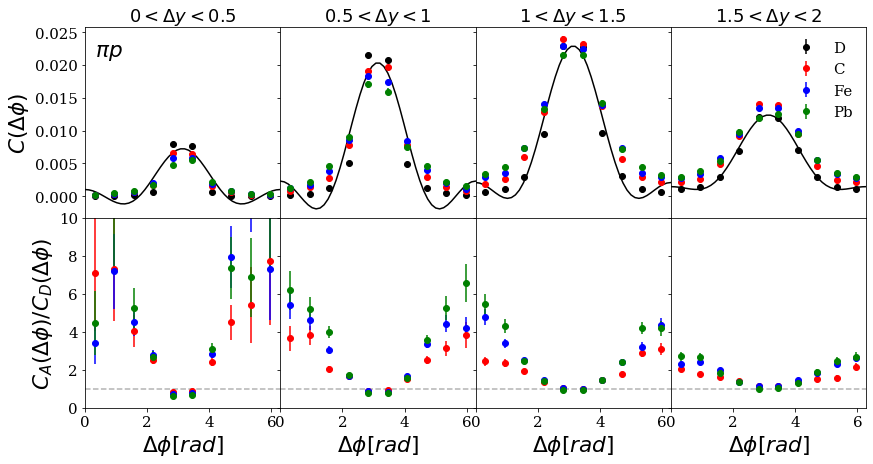

In [19]:

imp.reload(correlation_plots)
for label,topo,fillstyle,linestyleFit in zip('$\\pi\\pi$ $\\pi{}p$'.split(),
                                             '_2pi _pi_p'.split(),'full full'.split(), '----'):
    
    dyranges = [(0,0.5), (0.5,1), (1,1.5),(1.5,2)]
    fig,axs = plt.subplots(2,len(dyranges),figsize=(14,7),sharex='all',sharey='row')
    
    for j,dyrange in enumerate(dyranges):
        query = f"h2_z>0.1 and h1_z>0.5"
        if dyrange:
             query += f" and diff_rap_cm>{dyrange[0]} and diff_rap_cm<{dyrange[1]}"
        for a,col in zip('D C Fe Pb'.split(),"krbg"):
            A = dfs_data[a+topo].query(query)
            triggers_A = dfs_trigger[a].query('h1_z>0.5')
            mix_A = dfs_mixed[a+topo].query(query) 

            if a != 'D':
                D = dfs_data['D_'+a+topo].query(query)
                triggers_D = dfs_trigger['D_'+a].query('h1_z>0.5')
                mix_D = dfs_mixed['D_'+a+topo].query(query) 

            plt.sca(axs[0][j])
            #nuclear
            correlation_plots.general_1D_plot(A,None,df_triggers_A=triggers_A,
                          projyrange=(-1,3.0),bins1d=10,
                                                  df_mix_A=mix_A,color=col,label=a,
                                              plotFourier=2,fillstyle=fillstyle,linestyleFit='-' if a == 'D' else '')
            plt.sca(axs[1][j])
            #nuclear
            if a != 'D':
                correlation_plots.general_1D_plot(A,D,df_triggers_A=triggers_A,df_triggers_D=triggers_D,
                          projyrange=(-1,3.0),bins1d=10,
                                                  df_mix_A=mix_A,df_mix_D=mix_D,color=col,label=a,
                                              plotFourier=2 if topo=='_2pi' else 3,fillstyle=fillstyle,linestyleFit='-' if a == 'D' else '')
            plt.gca().set_xlim(0,2*np.pi)

        for ax in axs[1]:
            ax.set_xlabel("$\\Delta\\phi [rad]$")
        axs[1][j].axhline(1,color='0.7', linestyle='--')
        if topo=='_2pi':
            axs[1][j].set_ylim(0,1.5)
        else:
            axs[1][j].set_ylim(0,10)
            
        dyrangestr = f"${dyrange[0]}<\Delta y<{dyrange[1]}$" if dyrange else "all"
        axs[0][j].set_title(dyrangestr,fontsize='large')
    axs[0][0].text(.05,0.85, label,transform=axs[0][0].transAxes,fontsize='x-large')
        
    
    axs[0][0].set_ylabel("$C(\\Delta\\phi)$")
    axs[1][0].set_ylabel("$C_A(\\Delta\\phi)/C_D(\\Delta\\phi)$")
    axs[0][-1].legend(framealpha=0)
    fig.subplots_adjust(hspace=0,wspace=0)
    plt.savefig(image_dir+f"/summary_1d{topo}_slices.pdf",bbox_inches='tight')
    plt.show()

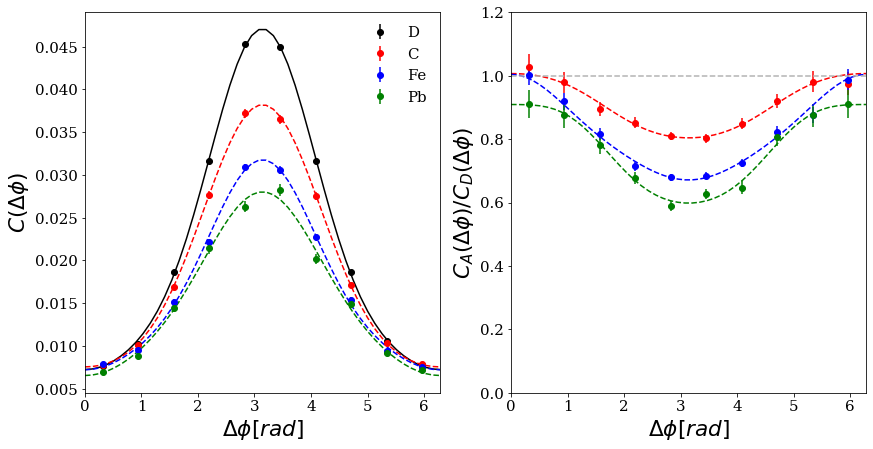

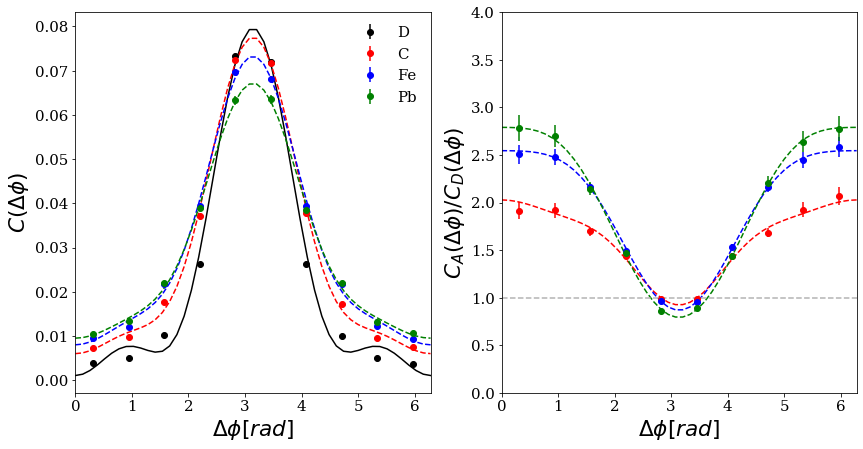

In [21]:

imp.reload(correlation_plots)
for label,topo,fillstyle,linestyleFit in zip('$\\pi\\pi$ $\\pi{}p$'.split(), '_2pi _pi_p'.split(),'full full'.split(), '- -'.split()):
    for dyrange in None,:
        
        fig,axs = plt.subplots(1,2,figsize=(14,7),sharex='all')
        query = f"h2_z>0.1 and h1_z>0.5"
        if dyrange:
             query += f" and diff_rap_cm>{dyrange[0]} and diff_rap_cm<{dyrange[1]}"
        for a,col in zip('D C Fe Pb'.split(),"krbg"):
            linestyleFit='-' if a == 'D' else '--'
            A = dfs_data[a+topo].query(query)
            triggers_A = dfs_trigger[a].query('h1_z>0.5')
            mix_A = dfs_mixed[a+topo].query(query) 

            if a != 'D':
                D = dfs_data['D_'+a+topo].query(query)
                triggers_D = dfs_trigger['D_'+a].query('h1_z>0.5')
                mix_D = dfs_mixed['D_'+a+topo].query(query) 

            plt.sca(axs[0])
            #nuclear
            correlation_plots.general_1D_plot(A,None,df_triggers_A=triggers_A,
                          projyrange=(0,3.0),bins1d=10,
                                                  df_mix_A=mix_A,color=col,label=a,
                                              plotFourier=3,fillstyle=fillstyle,linestyleFit=linestyleFit)
            plt.sca(axs[1])
            #nuclear
            if a != 'D':
                correlation_plots.general_1D_plot(A,D,df_triggers_A=triggers_A,df_triggers_D=triggers_D,
                          projyrange=(0,3.0),bins1d=10,
                                                  df_mix_A=mix_A,df_mix_D=mix_D,color=col,label=a,
                                              plotFourier=3,fillstyle=fillstyle,linestyleFit=linestyleFit)
            plt.gca().set_xlim(0,2*np.pi)

        for ax in axs:
            ax.set_xlabel("$\\Delta\\phi [rad]$")
        axs[0].set_ylabel("$C(\\Delta\\phi)$")
        axs[1].set_ylabel("$C_A(\\Delta\\phi)/C_D(\\Delta\\phi)$")
        axs[1].axhline(1,color='0.7', linestyle='--')
        if topo=='_2pi':
            axs[1].set_ylim(0,1.2)
        else:
            axs[1].set_ylim(0,4)

        axs[0].text(.05,0.85, label,transform=plt.gca().transAxes,fontsize='x-large')
        axs[0].text(.05,0.75, "1<$Q^2$<4 GeV$^2$\n$y$<0.85",transform=plt.gca().transAxes)
        axs[0].legend(framealpha=0)
        dyrangestr = f"_{dyrange[0]}_{dyrange[1]}" if dyrange else ""
        plt.savefig(image_dir+f"/summary_1d{topo}{dyrangestr}.pdf",bbox_inches='tight')
        plt.show()

(1, 10)

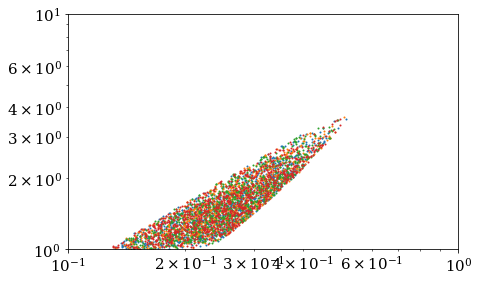

In [413]:
n=1000
for a in 'D C Fe Pb'.split():
    plt.scatter(dfs_data[a+'_2pi'][:n].x,dfs_data[a+'_2pi'][:n].Q2,1)
plt.gca().set_yscale('log')
plt.gca().set_xscale('log')
plt.gca().set_xlim(0.1,1)
plt.gca().set_ylim(1,10)